In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import re
# Scenario folder
folder = '../logs/mushrooms2/scenario_1'
indicators_filename = 'custom_indicators.json'
rewards_history_filename = 'rewards_history.txt'

# Colors for the generative agents architecture and the CoT architecture
SUBCAT_COLORS = [{'facecolor': 'lightblue', 'color': 'blue'},
    {'facecolor': 'lightgreen', 'color': 'green'}
]

In [2]:
def get_results_by_category_and_subcategory(indicators, llm_model, indicator_name, categories, agg_fn):
    """
    Returns a dictionary with the categories as keys and as values a dictionary with the subcategories as keys and a list 
    with the values for each simulation

    Parameters:
    indicators (dict): The indicators dictionary
    llm_model (str): The LLM model
    indicator_name (str): The name of the indicator
    categories (list): The name of the categories
    agg_fn (function): The function to aggregate the values for the agents
    """
    subcategories = list(indicators.keys())

    if indicator_name:
        subcategories_results = {subcat: get_indicator_by_simulation(indicators[subcat][llm_model], indicator_name) for subcat in subcategories}
    else:
        subcategories_results = {subcat: indicators[subcat][llm_model] for subcat in subcategories}
    
    # If there are no categories, return the results by subcategory
    if not categories:
        results = {}
        for subcat in subcategories:
            results[subcat] = agg_fn(subcategories_results[subcat], None)
        return results

    results_by_cat = {}
    for cat in categories:
        results_by_cat[cat] = {}
        for subcat in subcategories:
            results_by_cat[cat][subcat] = agg_fn(subcategories_results[subcat], cat)
    return results_by_cat

In [24]:
def create_box_plot(results, subcat_colors, norm_across_cats=False, **kwargs):
    """
    Creates a box plot with the results of the indicators
    The results are a dictionary with (categories) as keys and as values a dictionary with subcategories as keys and a list with the values for each simulation

    Parameters:
    results (dict): The results of the indicators
    subcat_colors (list): A list with the colors for each subcategory. Each element is a dictionary with the facecolor and the color
    norm_across_cats (bool): If True, the values will be normalized across categories
    **kwargs: Additional parameters for the plot. title and ylabel are supported
    """
    categories = list(results.keys())
    try:
        subcategories = list(results[categories[0]].keys())

    except:
        # If there are is an exception is because the data has no categories
        subcategories = categories
        categories = None
        

    if norm_across_cats and categories is not None:
        results = np.array(list(map(lambda x: list(x.values()), results.values()))) # 3 dimensions: categories, subcategories, simulations
        # Mask to avoid division by zero
        mask = results.sum(axis=0, keepdims=True) == 0
        results = results/(results.sum(axis=0, keepdims=True)+mask)

    if categories is None:
        positions = np.arange(len(subcategories))+1
    else:
        positions = np.arange(len(categories)*len(subcategories))+1

    for s, subcategory in enumerate(subcategories):
        boxprops = subcat_colors[s].copy()
        if categories is not None:
            if norm_across_cats:
                data = [results[c][s] for c in range(len(categories))]
            else:
                data = [results[c][subcategory] for c in categories]
        else:
            # data = results[s]
            data = results[subcategory]
        plt.boxplot(data, positions=positions[s::len(subcategories)], patch_artist=True, boxprops=boxprops, showmeans=True)

    if categories is not None:
        plt.xticks(positions[::len(subcategories)], categories)
    else:
        plt.xticks(positions, subcategories)

    if 'title' in kwargs:
        plt.title(kwargs['title'])
    if 'ylabel' in kwargs:
        plt.ylabel(kwargs['ylabel'])

    if categories is not None:
        legend_elements = [Patch(facecolor=subcat_colors[i]['facecolor'], edgecolor=subcat_colors[i]['color'], \
                                label=subcategory) for i, subcategory in enumerate(subcategories)]
        plt.legend(handles=legend_elements, loc='upper right')

    plt.show()


def create_line_plot(results, subcat_colors, agg=np.mean, norm_across_cats=False, **kwargs):
    """
    Creates a box plot with the results of the indicators
    The results are a dictionary with (categories) as keys and as values a dictionary with subcategories as keys and a list with the values for each simulation

    Parameters:
    results (dict): The results of the indicators
    subcat_colors (list): A list with the colors for each subcategory. Each element is a dictionary with the facecolor and the color
    agg (function): The function to aggregate the results. There should be a single value per category-subcategory
    norm_across_cats (bool): If True, the values will be normalized across categories
    **kwargs: Additional parameters for the plot. title and ylabel are supported
    """
    categories = list(results.keys())
    subcategories = list(results[categories[0]].keys())
    # results = np.array(list(map(lambda x: list(x.values()), results.values()))) # 3 dimensions: categories, subcategories, simulations

    # if norm_across_cats and categories is not None:
    #     # Mask to avoid division by zero
    #     mask = results.sum(axis=0, keepdims=True) == 0
    #     results = results/(results.sum(axis=0, keepdims=True)+mask)

    positions = np.arange(len(categories))

    for s, subcategory in enumerate(subcategories):
        data = [agg(results[c][subcategory]) for c in categories]
        plt.plot(data, label=subcategory, color=subcat_colors[s]['color'])

    plt.xticks(positions, categories)

    if 'title' in kwargs:
        plt.title(kwargs['title'])
    if 'ylabel' in kwargs:
        plt.ylabel(kwargs['ylabel'])
    if 'xlabel' in kwargs:
        plt.xlabel(kwargs['xlabel'])

    legend_elements = [Patch(facecolor=subcat_colors[i]['facecolor'], edgecolor=subcat_colors[i]['color'], \
                            label=subcategory) for i, subcategory in enumerate(subcategories)]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.show()

In [4]:
def take_juan_result(actions_indicator_by_sim, category):
        # If there is no category, return the results for Juan
        if category is None:
                return [sim['Juan'] if 'Juan' in sim else 0 for sim in actions_indicator_by_sim]

        return [sim['Juan'][category] if category in sim['Juan'] else 0 for sim in actions_indicator_by_sim]

In [5]:
def bots_mean(actions_indicator_by_sim, category):
    if category is None:
        result = [[sim[agent] for agent in sim if agent != 'Juan'] for sim in actions_indicator_by_sim]
    else:
        result = [[sim[agent][category] if category in sim[agent] else 0 for agent in sim if agent != 'Juan'] for sim in actions_indicator_by_sim]
    return [sum(cat_result)/len(cat_result) if len(cat_result) > 0 else 0 for cat_result in result]

# Reward analysis

In [6]:
def get_metrics_of_simulation(filename):
    rewards = {}
    exec_time = 0
    total_cost = 0
    with open(filename, 'r') as f:
        reward_patt = r'.*end_game:\d+ - Player (\w+): score is (\d+(\.\d+)?)'
        time_patt = r'.* - Execution time: (\d+(\.\d+)?)'
        cost_patt = r'.*- LLM total cost: (\d+(\.\d+)?)'
        for line in f:
            m_reward = re.search(reward_patt, line)
            m_time = re.search(time_patt, line)
            m_cost = re.search(cost_patt, line)
            if m_reward:
                rewards[m_reward.group(1)] = float(m_reward.group(2))
            elif m_cost:
                total_cost = float(m_cost.group(1))
            elif m_time:
                exec_time = float(m_time.group(1))
    return rewards, exec_time, total_cost

In [7]:
rewards = {}
costs = {}
exec_times = {}

In [8]:
new_arch = 'GA_world_model'
new_arch_folder = '../logs/mushrooms_understanding'
rewards[new_arch] = {}
costs[new_arch] = {}
exec_times[new_arch] = {}
rewards[new_arch]['gpt4o_mini'] = []
costs[new_arch]['gpt4o_mini'] = []
exec_times[new_arch]['gpt4o_mini'] = []
for sim_folder in os.listdir(new_arch_folder):
            # skip if it is not a folder
            if not os.path.isdir(os.path.join(new_arch_folder, sim_folder)):
                continue

            patt = r'\d{4}-\d{2}-\d{2}--\d{2}-\d{2}-\d{2}'
            folder_time = re.search(patt, sim_folder)
            rewards_filename = folder_time.group() + '.log'

            # Load the rewards of the simulation
            rewards_file = os.path.join(new_arch_folder, sim_folder, rewards_filename)
            sim_rewards, sim_time, sim_cost = get_metrics_of_simulation(rewards_file)
            rewards[new_arch]['gpt4o_mini'].append(sim_rewards)
            costs[new_arch]['gpt4o_mini'].append(sim_cost)
            exec_times[new_arch]['gpt4o_mini'].append(sim_time)

In [9]:
# Get the list of agents architectures
LAAs_models = os.listdir(folder)
# Iterate over the agents architectures
for model in LAAs_models:
    model_path = os.path.join(folder, model)
    # Get the list of LLMs
    llm_models = os.listdir(model_path)

    rewards[model] = {}
    costs[model] = {}
    exec_times[model] = {}

    # Iterate over the LLMs per agent architecture
    for llm_model in llm_models:
        # Get the list of simulations per LLM and agent architecture
        llm_model_path = os.path.join(model_path, llm_model)

        rewards[model][llm_model] = []
        costs[model][llm_model] = []
        exec_times[model][llm_model] = []

        # Iterate over the simulations
        for sim_folder in os.listdir(llm_model_path):
            # skip if it is not a folder
            if not os.path.isdir(os.path.join(llm_model_path, sim_folder)):
                continue

            patt = r'\d{4}-\d{2}-\d{2}--\d{2}-\d{2}-\d{2}'
            folder_time = re.search(patt, sim_folder)
            rewards_filename = folder_time.group() + '.log'

            # Load the rewards of the simulation
            rewards_file = os.path.join(llm_model_path, sim_folder, rewards_filename)
            sim_rewards, sim_time, sim_cost = get_metrics_of_simulation(rewards_file)
            rewards[model][llm_model].append(sim_rewards)
            costs[model][llm_model].append(sim_cost)
            exec_times[model][llm_model].append(sim_time)

Total costs

In [10]:
costs_results = {}
for arch in costs:
    costs_results[arch] = {}
    for llm in costs[arch]:
        costs_results[arch][llm] = {'mean': np.mean(costs[arch][llm]), 'std': np.std(costs[arch][llm])}

# Make a table with the costs
df = pd.DataFrame(costs_results)
df

,GA_world_model,generative_agents,cot_agent
gpt4o_mini,"{'mean': 0.23700000000000002, 'std': 0.0740337...","{'mean': 0.293, 'std': 0.1129645962237727}","{'mean': 0.012, 'std': 0.005999999999999999}"
gpt4o,NaN,"{'mean': 10.193999999999999, 'std': 6.13014551...","{'mean': 0.279, 'std': 0.10709341716464182}"


Total execution time

In [11]:
time_results = {}
for arch in exec_times:
    time_results[arch] = {}
    for llm in exec_times[arch]:
        time_results[arch][llm] = {'mean': np.mean(exec_times[arch][llm]), 'std': np.std(exec_times[arch][llm])}

# Make a table with the costs
df = pd.DataFrame(time_results)
df

,GA_world_model,generative_agents,cot_agent
gpt4o_mini,"{'mean': 115.33400000000002, 'std': 38.3429404...","{'mean': 67.264, 'std': 39.52380781250714}","{'mean': 6.189, 'std': 2.1486854120601278}"
gpt4o,NaN,"{'mean': 115.04699999999998, 'std': 60.4035798...","{'mean': 4.8660000000000005, 'std': 1.74600229..."


Total rewards

In [12]:
rewards_results = {}
for arch in rewards:
    rewards_results[arch] = {}
    for llm in rewards[arch]:
        data = list(map(lambda x: x['Juan'], rewards[arch].get(llm, [])))
        rewards_results[arch][llm] = {'mean': np.mean(data), 'std': np.std(data)}

# Make a table with the costs
df = pd.DataFrame(rewards_results)
df

,GA_world_model,generative_agents,cot_agent
gpt4o_mini,"{'mean': 21.764999999999997, 'std': 11.3131129...","{'mean': 17.675, 'std': 7.404297738475945}","{'mean': 14.955000000000002, 'std': 6.33227644..."
gpt4o,NaN,"{'mean': 17.155, 'std': 9.904858656235334}","{'mean': 11.83, 'std': 6.414990257202267}"


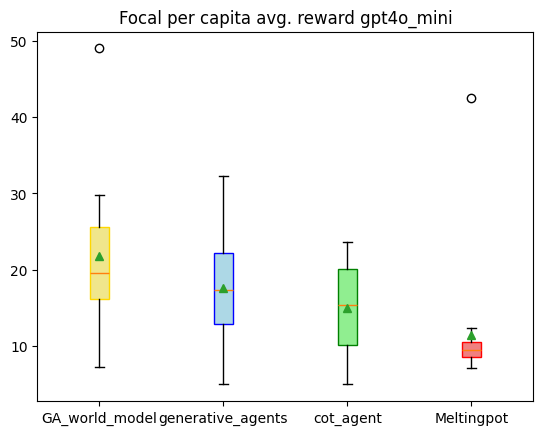

In [25]:
rewards_results = get_results_by_category_and_subcategory(rewards, 'gpt4o_mini', None, None, take_juan_result)
rewards_results['Meltingpot'] = [
    9.515864759,
    9.772210377,
    9.853513703,
    8.705473098,
    8.989089184,
    7.784704519,
    42.44193548,
    10.36856801,
    9.565817449,
    8.978874068,
    8.389238845,
    7.167383513,
    7.480203237,
    12.31393855,
    11.18722784,
    11.66918489
]

title = 'Focal per capita avg. reward gpt4o_mini'
subcat_colors = [{'facecolor': 'khaki', 'color': 'gold'}] + SUBCAT_COLORS + [{'facecolor': 'lightcoral', 'color': 'red'}]
create_box_plot(rewards_results, subcat_colors, title=title)

T-tests between architecture results

In [14]:
from scipy.stats import t
import math

archs = list(rewards_results.keys())

def calculate_sig_of_diff(results1, results2, lower_tail=False):
    se1 = np.var(results1, ddof=1)/len(results1)
    se2 = np.var(results2, ddof=1)/len(results2)
    t_score = (np.mean(results1) - np.mean(results2))/np.sqrt(se1 + se2)
    df = (se1**2  + se2**2)** 2 / (se1**4/(len(results1)-1) + se2**4/(len(results2)-1))
    df = math.floor(df)

    if lower_tail:
        p = t.cdf(t_score, df)
    else:
        p = 1 - t.cdf(t_score, df)
    return t_score, p

for i in range(len(archs)):
    for j in range(i+1, len(archs)):
        t_score, p = calculate_sig_of_diff(rewards_results[archs[i]], rewards_results[archs[j]])
        print(f'{archs[i]} vs {archs[j]}: t={t_score}, p={p}')

GA_world_model vs generative_agents: t=0.9074953538338693, p=0.19100381124771548
GA_world_model vs cot_agent: t=1.5758136434968193, p=0.07307335251178493
GA_world_model vs Meltingpot: t=2.37729843248842, p=0.01939546219191579
generative_agents vs cot_agent: t=0.8375451066817415, p=0.2073112315607557
generative_agents vs Meltingpot: t=1.90449878284208, p=0.036954399112738234
cot_agent vs Meltingpot: t=1.158355036431085, p=0.1295697783614529


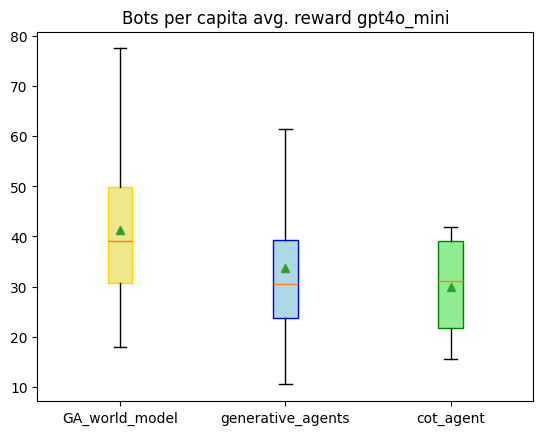

In [26]:
rewards_results = get_results_by_category_and_subcategory(rewards, 'gpt4o_mini', None, None, bots_mean)

title = 'Bots per capita avg. reward gpt4o_mini'
create_box_plot(rewards_results, [{'facecolor': 'khaki', 'color': 'gold'}] + SUBCAT_COLORS, title=title)

## Gini coefficient

In [27]:
def take_cat_result(actions_indicator_by_sim, category):
        # If there is no category, return the results for Juan
        if category is None:
                return actions_indicator_by_sim

        return [sim[category] if category in sim else 0 for sim in actions_indicator_by_sim]

In [28]:
agents = ['Juan', 'bot_1', 'bot_2', 'bot_3', 'bot_4']
reward_by_agennt_by_arch = get_results_by_category_and_subcategory(rewards, 'gpt4o_mini', None, agents, take_cat_result)

In [29]:
# Calculate the gini coefficient
def gini(x):
    """
    Calculate the Gini coefficient of a numpy array.

    Parameters:
    x (numpy array): The array with the values, wher
    """
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [31]:
gini_coefs0 = []
reward_by_agent_arch1 = [agent_result['GA_world_model'] for agent_result in reward_by_agennt_by_arch.values()]
for sim in range(len(reward_by_agent_arch1[0])):
    rewards_by_agent = [agent[sim] for agent in reward_by_agent_arch1]
    gini_coefs0.append(gini(rewards_by_agent))

gini_coefs1 = []
reward_by_agent_arch1 = [agent_result['generative_agents'] for agent_result in reward_by_agennt_by_arch.values()]
for sim in range(len(reward_by_agent_arch1[0])):
    rewards_by_agent = [agent[sim] for agent in reward_by_agent_arch1]
    gini_coefs1.append(gini(rewards_by_agent))

gini_coefs2 = []
reward_by_agent_arch2 = [agent_result['cot_agent'] for agent_result in reward_by_agennt_by_arch.values()]
for sim in range(len(reward_by_agent_arch2[0])):
    rewards_by_agent = [agent[sim] for agent in reward_by_agent_arch2]
    gini_coefs2.append(gini(rewards_by_agent))

gini_coefs_by_arch = {'GA_world_model': gini_coefs0 ,'generative_agents': gini_coefs1, 'cot_agent': gini_coefs2}

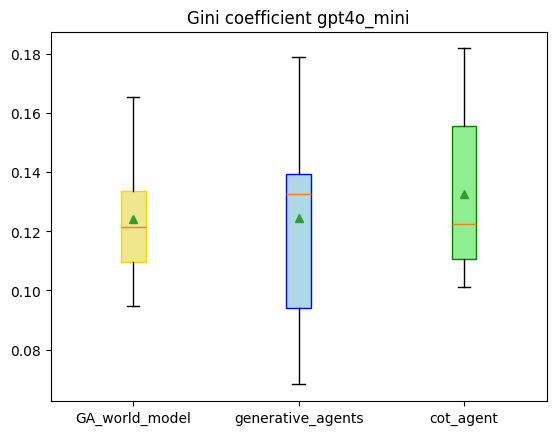

In [32]:
create_box_plot(gini_coefs_by_arch, [{'facecolor': 'khaki', 'color': 'gold'}] + SUBCAT_COLORS, title='Gini coefficient gpt4o_mini')

In [33]:
archs = list(gini_coefs_by_arch.keys())

for i in range(len(archs)):
    for j in range(i+1, len(archs)):
        t_score, p = calculate_sig_of_diff(gini_coefs_by_arch[archs[i]], gini_coefs_by_arch[archs[j]], lower_tail=True)
        print(f'{archs[i]} vs {archs[j]}: t={t_score}, p={p}')

GA_world_model vs generative_agents: t=-0.016553140684928608, p=0.4935447662805551
GA_world_model vs cot_agent: t=-0.729527289306658, p=0.23845880451014767
generative_agents vs cot_agent: t=-0.5512114286606704, p=0.29508904975155614


## Custom indicators for the scenario

First, get all the indicators' results for each model.

The file structure for the scenario simulations should be the following:
* agent_architecture
    * llm_model
        * simulations


The indicators will be held in a dictionary with the following structure:
`{agent_architecture: {llm_model: [simulation_1_indicators,]}}`

In [35]:
indicators = {}
new_arch = 'GA_world_model'
new_arch_folder = '../logs/mushrooms_understanding'
indicators[new_arch] = {}
indicators[new_arch]['gpt4o_mini'] = []
for sim_folder in os.listdir(new_arch_folder):
    # skip if it is not a folder
    if not os.path.isdir(os.path.join(new_arch_folder, sim_folder)):
        continue

    # Load the indicators
    indicators_per_sim = os.path.join(new_arch_folder, sim_folder, indicators_filename)
    with open(indicators_per_sim, 'r') as file:
        indicators_per_sim = json.load(file)

    # Add the indicators to the global dictionary
    indicators[new_arch]['gpt4o_mini'].append(indicators_per_sim)

In [36]:
# Get the list of agents architectures
LAAs_models = os.listdir(folder)
# Iterate over the agents architectures
for model in LAAs_models:
    model_path = os.path.join(folder, model)
    # Get the list of LLMs
    llm_models = os.listdir(model_path)

    indicators[model] = {}

    # Iterate over the LLMs per agent architecture
    for llm_model in llm_models:
        # Get the list of simulations per LLM and agent architecture
        llm_model_path = os.path.join(model_path, llm_model)

        indicators[model][llm_model] = []

        # Iterate over the simulations
        for sim_folder in os.listdir(llm_model_path):
            # skip if it is not a folder
            if not os.path.isdir(os.path.join(llm_model_path, sim_folder)):
                continue

            # Load the indicators
            indicators_per_sim = os.path.join(llm_model_path, sim_folder, indicators_filename)
            with open(indicators_per_sim, 'r') as file:
                indicators_per_sim = json.load(file)

            # Add the indicators to the global dictionary
            indicators[model][llm_model].append(indicators_per_sim)

In [37]:
def get_indicator_by_simulation(indicators, indicator_name):
    """
    Returns a list with the value of the indicator scpecified for each simulation
    """
    return [sim[indicator_name] if indicator_name in sim else {} for sim in indicators]

### Actions taken by the LLM

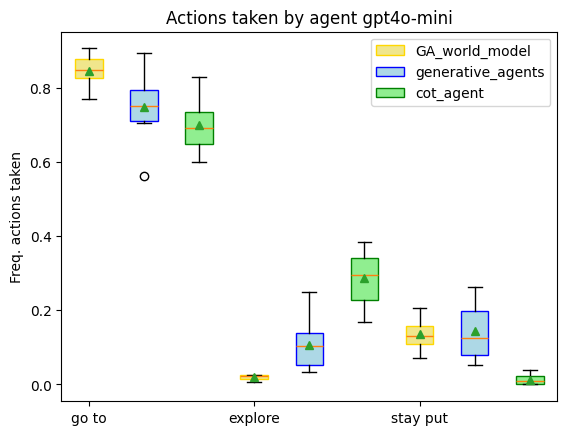

In [38]:
title = 'Actions taken by agent gpt4o-mini'
ylabel = 'Freq. actions taken'
actions_taken = get_results_by_category_and_subcategory(indicators, 'gpt4o_mini', 'actions_taken', ['go to', 'explore', 'stay put'], take_juan_result)
create_box_plot(actions_taken, [{'facecolor': 'khaki', 'color': 'gold'}] + SUBCAT_COLORS, norm_across_cats=True, title=title, ylabel=ylabel)
                

### Mushroom-type consumption

Mushroom-type consumption of agent Juan

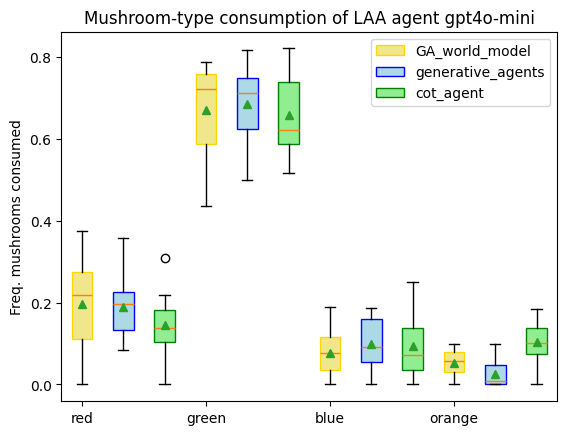

In [39]:
mushroom_type_consumption = get_results_by_category_and_subcategory(indicators, 'gpt4o_mini', 'mushrooms_consumption', ['red', 'green', 'blue', 'orange'], take_juan_result)
title = 'Mushroom-type consumption of LAA agent gpt4o-mini'
ylabel = 'Freq. mushrooms consumed'
create_box_plot(mushroom_type_consumption, [{'facecolor': 'khaki', 'color': 'gold'}] + SUBCAT_COLORS, norm_across_cats=True, title=title, ylabel=ylabel)

Mushroom-type consumption of bots

In [40]:
def bots_mean(actions_indicator_by_sim, category):
    if category is None:
        result = [[sim[agent] for agent in sim if agent != 'Juan'] for sim in actions_indicator_by_sim]
    else:
        result = [[sim[agent][category] if category in sim[agent] else 0 for agent in sim if agent != 'Juan'] for sim in actions_indicator_by_sim]
    return [sum(cat_result)/len(cat_result) if len(cat_result) > 0 else 0 for cat_result in result]

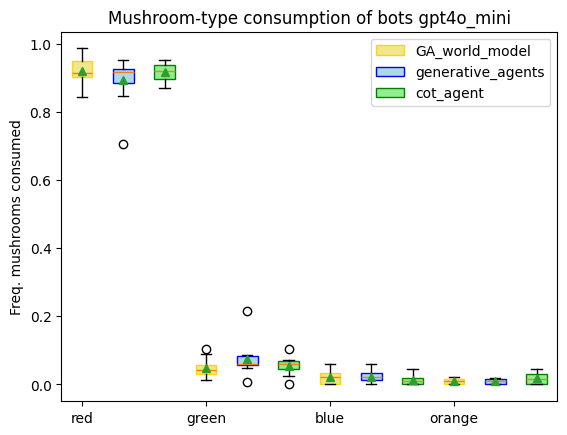

In [41]:
mushroom_type_consumption = get_results_by_category_and_subcategory(indicators, 'gpt4o_mini', 'mushrooms_consumption', ['red', 'green', 'blue', 'orange'], bots_mean)
title = 'Mushroom-type consumption of bots gpt4o_mini'
ylabel = 'Freq. mushrooms consumed'
create_box_plot(mushroom_type_consumption, [{'facecolor': 'khaki', 'color': 'gold'}] + SUBCAT_COLORS, norm_across_cats=True, title=title, ylabel=ylabel)

### Digesting spent time

Digesting spent time of Juan

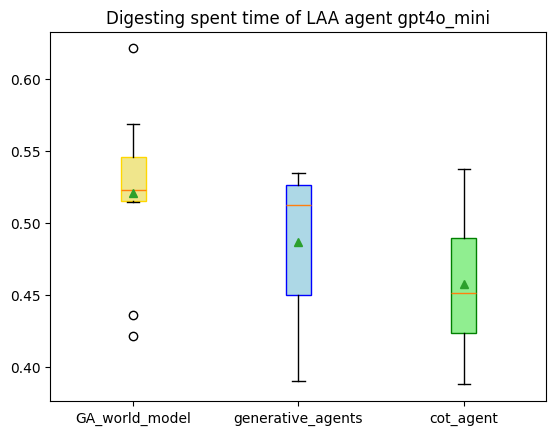

In [42]:
digesting_spent_time = get_results_by_category_and_subcategory(indicators, 'gpt4o_mini', 'digesting_spent_time', None, take_juan_result)
title = 'Digesting spent time of LAA agent gpt4o_mini'
create_box_plot(digesting_spent_time, [{'facecolor': 'khaki', 'color': 'gold'}] + SUBCAT_COLORS, norm_across_cats=True, title=title)

Digesting spent time of bots

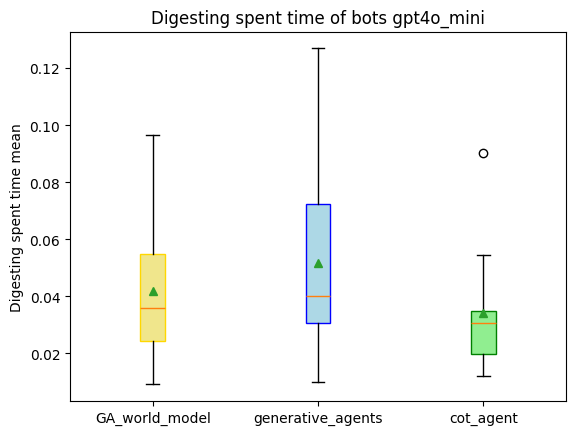

In [43]:
digesting_spent_time = get_results_by_category_and_subcategory(indicators, 'gpt4o_mini', 'digesting_spent_time', None, bots_mean)
title = 'Digesting spent time of bots gpt4o_mini'
ylabel = 'Digesting spent time mean'
create_box_plot(digesting_spent_time, [{'facecolor': 'khaki', 'color': 'gold'}] + SUBCAT_COLORS, norm_across_cats=True, title=title, ylabel=ylabel)